### ME3:

In [1]:
# Standard library imports
import os
import time
import json
from collections import defaultdict
from functools import wraps
from pathlib import Path
from typing import Tuple

# Third-party imports
import lightning as L
import torch
from einops import einsum
from torch.optim.lr_scheduler import MultiStepLR
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import CIFAR10
from torchvision.models import ResNet18_Weights, resnet18, ResNet
from torch import nn
from torchmetrics.classification import Accuracy
from torch.nn.utils import prune
from tqdm.auto import tqdm

# set precision for matmuls
torch.set_float32_matmul_precision("medium")   # or "medium"

# Resolve storage locations for local runs and Google Drive
def resolve_base_dir() -> Path:
    env_override = os.environ.get("AI231_BASE_DIR")
    if env_override:
        return Path(env_override).expanduser()

    cwd = Path.cwd()
    drive_root = Path("/content/drive/MyDrive")
    if drive_root.exists():
        try:
            cwd.relative_to(drive_root)
        except ValueError:
            project_dir = drive_root / "ai231"
            project_dir.mkdir(parents=True, exist_ok=True)
            return project_dir
        else:
            return cwd

    return cwd

BASE_DIR = resolve_base_dir()
DATA_ROOT = BASE_DIR / "data" / "CIFAR10"
ARTIFACT_DIR = BASE_DIR / "artifacts" / "me3"
CKPT_PATH = ARTIFACT_DIR / "resnet18_finetuned.ckpt"


/home/aleisley/Documents/ai231/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
weights_and_biases = ResNet18_Weights.DEFAULT.get_state_dict()
print(weights_and_biases.keys())

odict_keys(['conv1.weight', 'bn1.running_mean', 'bn1.running_var', 'bn1.weight', 'bn1.bias', 'layer1.0.conv1.weight', 'layer1.0.bn1.running_mean', 'layer1.0.bn1.running_var', 'layer1.0.bn1.weight', 'layer1.0.bn1.bias', 'layer1.0.conv2.weight', 'layer1.0.bn2.running_mean', 'layer1.0.bn2.running_var', 'layer1.0.bn2.weight', 'layer1.0.bn2.bias', 'layer1.1.conv1.weight', 'layer1.1.bn1.running_mean', 'layer1.1.bn1.running_var', 'layer1.1.bn1.weight', 'layer1.1.bn1.bias', 'layer1.1.conv2.weight', 'layer1.1.bn2.running_mean', 'layer1.1.bn2.running_var', 'layer1.1.bn2.weight', 'layer1.1.bn2.bias', 'layer2.0.conv1.weight', 'layer2.0.bn1.running_mean', 'layer2.0.bn1.running_var', 'layer2.0.bn1.weight', 'layer2.0.bn1.bias', 'layer2.0.conv2.weight', 'layer2.0.bn2.running_mean', 'layer2.0.bn2.running_var', 'layer2.0.bn2.weight', 'layer2.0.bn2.bias', 'layer2.0.downsample.0.weight', 'layer2.0.downsample.1.running_mean', 'layer2.0.downsample.1.running_var', 'layer2.0.downsample.1.weight', 'layer2.0.do

In [50]:
weights_and_biases['fc.weight']

Parameter containing:
tensor([[-0.0185, -0.0705, -0.0518,  ..., -0.0390,  0.1735, -0.0410],
        [-0.0818, -0.0944,  0.0174,  ...,  0.2028, -0.0248,  0.0372],
        [-0.0332, -0.0566, -0.0242,  ..., -0.0344, -0.0227,  0.0197],
        ...,
        [-0.0103,  0.0033, -0.0359,  ..., -0.0279, -0.0115,  0.0128],
        [-0.0359, -0.0353, -0.0296,  ..., -0.0330, -0.0110, -0.0513],
        [ 0.0021, -0.0248, -0.0829,  ...,  0.0417, -0.0500,  0.0663]],
       requires_grad=True)

#### Load the Datasets

In [3]:
class CIFAR10DataModule(L.LightningDataModule):
    def __init__(
            self, 
            data_dir: str = "data/CIFAR10", 
            batch_size: int = 256, 
            num_workers: int = 0
        ):
        super().__init__()
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.transform = ResNet18_Weights.IMAGENET1K_V1.transforms()

    def setup(self, stage: str | None = None):
        self.generator = torch.Generator().manual_seed(42)

        if stage in (None, 'fit', 'validate'):
            cifar10_full = CIFAR10(
                root=self.data_dir,
                train=True,
                transform=self.transform,
                download=True,
            )
            self.cifar10_train, self.cifar10_val = random_split(
                cifar10_full, [45000, 5000], generator=self.generator
            )
        
        if stage in (None, "test", "predict"):
            self.cifar10_test = CIFAR10(
                root=self.data_dir,
                train=False,
                transform=self.transform,
                download=True,
            )

    def train_dataloader(self):
        return DataLoader(
            self.cifar10_train,
            batch_size=self.batch_size,
            shuffle=True,
            num_workers=self.num_workers,
            persistent_workers=False,
            pin_memory=True,
            drop_last=True,
        )

    def val_dataloader(self):
        return DataLoader(
            self.cifar10_val,
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=0,
            pin_memory=True,
            persistent_workers=False,
        )

    def test_dataloader(self):
        return DataLoader(
            self.cifar10_test,
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=self.num_workers,
            pin_memory=True,
            persistent_workers=self.num_workers > 0,
        )


#### Initialize the model and replace head

In [4]:
class LitResnet18(L.LightningModule):
    def __init__(self, num_classes: int = 10, lr: float = 1e-3):
        super().__init__()
        self.save_hyperparameters()
        self.model = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
        self.model.fc = nn.Linear(512, num_classes)

        # freeze backbone
        for name, p in self.model.named_parameters():
            if not name.startswith("fc"):
                p.requires_grad = False

        self.loss = nn.CrossEntropyLoss()
        self.val_acc = Accuracy(task="multiclass", num_classes=num_classes)
        self.test_acc = Accuracy(task="multiclass", num_classes=num_classes)
        self.train_acc = Accuracy(task="multiclass", num_classes=num_classes)

    def forward(self, x):
        return self.model(x)

    def _shared_step(self, batch, batch_idx) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        x, y = batch
        logits = self(x)
        loss = self.loss(logits, y)
        preds = torch.argmax(logits, dim=1)
        return loss, preds, y

    def training_step(self, batch, batch_idx):
        loss, preds, y = self._shared_step(batch, batch_idx)
        self.train_acc.update(preds, y)
        self.log("train_loss", loss, on_step=True, on_epoch=True, prog_bar=True, sync_dist=True)
        self.log("train_acc", self.train_acc, on_step=False, on_epoch=True, prog_bar=True, sync_dist=True)
        return loss

    def validation_step(self, batch, batch_idx):
        loss, preds, y = self._shared_step(batch, batch_idx)
        self.val_acc.update(preds, y)
        self.log("val_loss", loss, on_step=False, on_epoch=True, prog_bar=True, sync_dist=True)
        self.log("val_acc", self.val_acc, on_step=False, on_epoch=True, prog_bar=True, sync_dist=True)

    def test_step(self, batch, batch_idx):
        loss, preds, y = self._shared_step(batch, batch_idx)
        self.test_acc.update(preds, y)
        self.log("test_loss", loss, on_step=False, on_epoch=True, prog_bar=True, sync_dist=True)
        self.log("test_acc", self.test_acc, on_step=False, on_epoch=True, prog_bar=True, sync_dist=True)

    def configure_optimizers(self):
        trainable = (p for p in self.parameters() if p.requires_grad)
        optimizer = torch.optim.SGD(
            trainable, lr=self.hparams.lr, momentum=0.9, weight_decay=1e-4
        )
        scheduler = MultiStepLR(optimizer, milestones=[30, 60], gamma=0.1)
        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": scheduler,
                "interval": "epoch",
                "frequency": 1,
            }
        }




#### Initial training of new head

In [5]:
ckpt_path = CKPT_PATH
ckpt_path.parent.mkdir(parents=True, exist_ok=True)

cifar10_dm = CIFAR10DataModule(num_workers=0)

if ckpt_path.exists():
    print(f"Loading {ckpt_path}")
    model = LitResnet18.load_from_checkpoint(ckpt_path)
else:
    print("No checkpoint found; training a new model.")
    model = LitResnet18()
    trainer = L.Trainer(max_epochs=90)
    trainer.fit(model, datamodule=cifar10_dm)
    trainer.save_checkpoint(ckpt_path)



Loading /home/aleisley/Documents/ai231/machine_exercises/artifacts/me3/resnet18_finetuned.ckpt


#### Testing accuracy following the new head

In [9]:
# Evaluate the fine-tuned head on the held-out test set
eval_trainer = L.Trainer()
test_results = eval_trainer.test(model, datamodule=cifar10_dm, verbose=False)

if test_results:
    metrics = test_results[0]
    test_acc = metrics.get("test_acc")
    if test_acc is not None:
        print(f"Test Accuracy: {test_acc:.4f}")
    print(metrics)


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 40/40 [00:23<00:00,  1.73it/s]
Test Accuracy: 0.7570
{'test_loss': 0.7320987582206726, 'test_acc': 0.7570000290870667}


Yes—around 60 cycles is a sensible upper bound if you keep pruning 5 % of the remaining head weights per cycle.

Here’s why:

With s = 0.05 per cycle, total sparsity after n cycles is

1−0.95n
1−0.95
n

So:

20 cycles → ~64 % total sparsity

40 cycles → ~87 % total sparsity

60 cycles → ~95 % total sparsity

95 % total sparsity is right at the range where most ResNet-18 heads can no longer recover validation accuracy.
Beyond that, recovery is usually negligible and training time is wasted.

Going much past 60 cycles gives very small additional pruning (e.g., 80 cycles only brings you to ~98 % sparsity) and very low accuracy.

#### Prune cycle

In [ ]:
artifact_dir = ARTIFACT_DIR
artifact_dir.mkdir(parents=True, exist_ok=True)
results_path = artifact_dir / 'pruning_results.json'

num_cycles = 30
prune_amount = 0.10  # 95% sparsity will be reached in 30 cycles

results = json.loads(results_path.read_text()) if results_path.exists() else []
completed = {entry['cycle'] for entry in results}

if completed:
    last_cycle = max(completed)
    resume_ckpt = artifact_dir / f"cycle_{last_cycle:02d}.ckpt"
    if resume_ckpt.exists():
        print(f"Resuming from {resume_ckpt}")
        model = LitResnet18.load_from_checkpoint(resume_ckpt)
    else:
        print(f"Checkpoint for cycle {last_cycle:02d} not found; continuing with current model.")

for cycle in range(1, num_cycles + 1):
    if cycle in completed:
        continue

    layer = model.model.fc
    prune.l1_unstructured(layer, name="weight", amount=prune_amount)

    prune_trainer = L.Trainer(max_epochs=5)
    prune_trainer.fit(model, datamodule=cifar10_dm)

    val_results = prune_trainer.validate(model, datamodule=cifar10_dm, verbose=False)
    val_acc = float(val_results[0]["val_acc"])
    results.append({"cycle": cycle, "val_acc": val_acc})
    completed.add(cycle)

    ckpt_name = f"cycle_{cycle:02d}.ckpt"
    prune_trainer.save_checkpoint(artifact_dir / ckpt_name)
    results_path.write_text(json.dumps(results, indent=2))

    model = prune_trainer.lightning_module


#### Plot the performance-#pruning curve

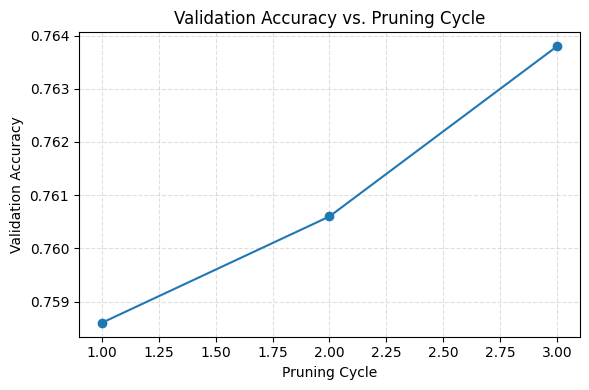

In [15]:
# Plot validation accuracy against pruning cycle
import matplotlib.pyplot as plt

if 'results_path' in globals() and results_path.exists():
    pruning_history = json.loads(results_path.read_text())
elif 'results' in globals():
    pruning_history = results
else:
    pruning_history = []

if not pruning_history:
    print('No pruning results available yet. Run the pruning loop first.')
else:
    cycles = [entry['cycle'] for entry in pruning_history]
    val_accs = [entry['val_acc'] for entry in pruning_history]

    plt.figure(figsize=(6, 4))
    plt.plot(cycles, val_accs, marker='o')
    plt.xlabel('Pruning Cycle')
    plt.ylabel('Validation Accuracy')
    plt.title('Validation Accuracy vs. Pruning Cycle')
    plt.grid(True, linestyle='--', alpha=0.4)
    plt.tight_layout()
    plt.show()


#### Test the pruned model

In [ ]:
# Evaluate the checkpoint recorded just before the steepest validation drop
if 'results_path' in globals() and results_path.exists():
    pruning_history = json.loads(results_path.read_text())
elif 'results' in globals():
    pruning_history = results
else:
    pruning_history = []

if len(pruning_history) < 2:
    print('Need at least two pruning cycles to analyze drops.')
else:
    deltas = []
    for prev, curr in zip(pruning_history, pruning_history[1:]):
        delta = curr['val_acc'] - prev['val_acc']
        deltas.append((delta, prev['cycle'], curr['cycle']))

    steepest_drop = min(deltas, key=lambda item: item[0])
    drop_value, before_cycle, after_cycle = steepest_drop
    if drop_value >= 0:
        print('Validation accuracy never decreased; nothing to evaluate.')
    else:
        target_cycle = before_cycle
        print(f"Steepest drop: {drop_value:.4f} between cycles {before_cycle} -> {after_cycle}.")
        ckpt_path = ARTIFACT_DIR / f"cycle_{target_cycle:02d}.ckpt"
        if not ckpt_path.exists():
            print(f"Checkpoint {ckpt_path} not found.")
        else:
            eval_model = LitResnet18.load_from_checkpoint(ckpt_path)
            eval_model.eval()
            eval_trainer = L.Trainer()
            test_metrics = eval_trainer.test(eval_model, datamodule=cifar10_dm, verbose=False)
            if test_metrics:
                metrics = test_metrics[0]
                test_acc = metrics.get('test_acc')
                if test_acc is not None:
                    print(f"Test accuracy before drop (cycle {target_cycle:02d}): {test_acc:.4f}")
                print(metrics)
